In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
import sklearn as sk
matplotlib.style.use('ggplot')

In [3]:
df = pd.read_csv('output.csv',delimiter=',')

In [4]:
# timestamps are in UTC time
parse_timestamps = lambda x : dt.datetime.strptime(x[:-5],'%Y-%m-%dT%H:%M:%S')
df['timestamp_parsed'] = df['timestamp'].apply(parse_timestamps)

# get rid of extra stuff in messages
msg_cleaner = lambda x: x[2:-1]
df['msg_contents_parsed'] = df['msg_contents'].apply(msg_cleaner)

# convert to EST time: move 4hrs back
utc_offset = np.timedelta64(-4,'h')
df['timestamp_parsed_EST'] = df['timestamp_parsed'] + utc_offset

# split msg time and msg date
df['msg_date'] = df['timestamp_parsed_EST'].apply(lambda x: x.date())
df['msg_time'] = df['timestamp_parsed_EST'].apply(lambda x: x.time())

# sort msgs chronologically
df = df.sort_values(by='timestamp_parsed_EST',ascending=True)

In [5]:
# adding msg length
df['msg_length'] = df['msg_contents_parsed'].apply(lambda x:len(x))

# adding distance between messages
df['msg_time_gap'] = df['timestamp_parsed_EST'].diff(periods=1).astype('timedelta64[s]')

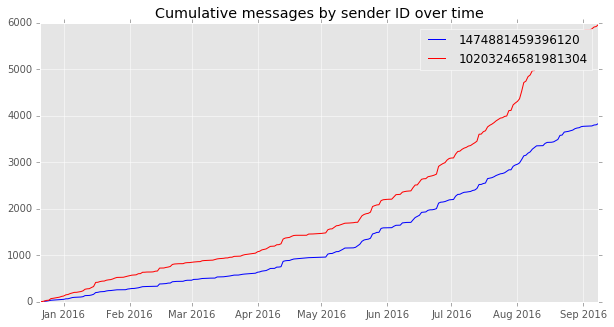

In [6]:
total_msgs = df.groupby(by=['sender_id','msg_date']).size()
participants = total_msgs.index.get_level_values(0).unique()

plt.figure(figsize=(10,5))
plt.plot(total_msgs[participants[0]].cumsum(),'b')
plt.plot(total_msgs[participants[1]].cumsum(),'r')
plt.legend((str(total_msgs.index.levels[0][0]),str(total_msgs.index.levels[0][1])))
plt.title('Cumulative messages by sender ID over time')
plt.show()

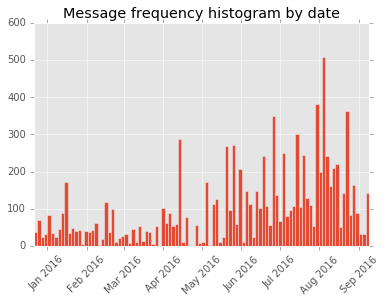

In [7]:
# first cluster and aggregate groups of messages together (like convos)

# plt.plot(x=df['timestamp_parsed_EST'],y=np.zeros_like(df['timestamp_parsed_EST']))
msg_times = df['timestamp_parsed_EST'] #.astype(np.int64)
# plt.plot(msgs,np.zeros_like(msgs),'x')

msg_times.hist(bins=100)
plt.xticks(rotation=45)
plt.title('Message frequency histogram by date')
plt.show()

# Common words, topic detection

In [8]:
msgs = df[['timestamp_parsed_EST','sender_id','msg_contents_parsed']].reset_index()

In [9]:
# using k-means to find clusters of messages (rough approx to a convo)
X = msg_times.reshape(-1,1)
# estimating number of conversations: tota l messages / 75
num_clusters = msgs.size//75
model = KMeans(n_clusters=num_clusters).fit(X)
Y_pred = model.predict(X)
msgs['predicted_cluster'] = Y_pred

/home/mattreyes/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64.
  warnings.warn(msg, DataConversionWarning)


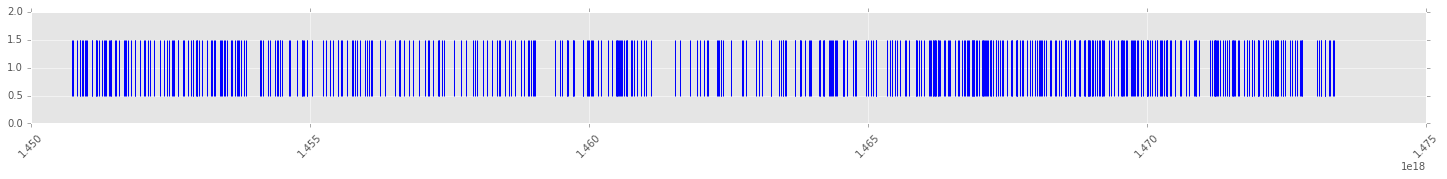

In [10]:
# plot centroids
plt.figure(figsize=(25,2))
plt.xticks(rotation=45)
centers = model.cluster_centers_.reshape(1,-1)

plt.eventplot(centers)
plt.show()

In [11]:
from sklearn import feature_extraction
# stopwords from nltk corpus
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']
extra_words = ['lol','brb','omg','like','no_message_found','yeah','nice','don','go','also','really','want','oh','aww','yo','hey','get','cause','kk','ye','ay','ayy','man','lemme','idk','shit','maybe','mhmm','gimme','ok','cool','nvm','im','maybe','sec','lmao','www','https','http','10','30','11','20','ill','got','back','yep','ya']
stopwords_aug = stopwords + extra_words

# aggregates messages by sender or by convo
all_msgs = msgs.groupby('sender_id')['msg_contents_parsed'].apply(lambda x: " ".join(x))
agg_msgs = msgs.groupby('predicted_cluster')['msg_contents_parsed'].apply(lambda x: " ".join(x))

# topic detection using non-negative matrix factorization of the tfidf mtx
vectorizer = sk.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_aug,use_idf=True,min_df=3)
M = vectorizer.fit_transform(agg_msgs)

# vectorizer.vocabulary_ is a dict with terms as keys and values as mtx indices
total_terms = len(vectorizer.vocabulary_)
terms = [''] * total_terms
for term in vectorizer.vocabulary_.keys():
    terms[vectorizer.vocabulary_[term]] = term


In [12]:
k = 10
model = sk.decomposition.NMF(init='nndsvd',n_components=k,max_iter=500)
W = model.fit_transform(M)
H = model.components_

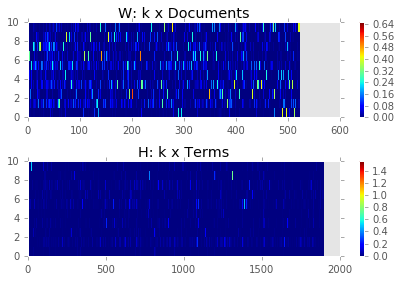

In [13]:
# visualizing matrices
plt.subplot(2,1,1)
plt.title("W: k x Documents")
plt.pcolormesh(W.T)
plt.colorbar()

plt.subplot(2,1,2)
plt.title("H: k x Terms")
plt.pcolormesh(H)
plt.colorbar()

plt.tight_layout()

In [14]:
num_topics = H.shape[0]

print("Printing top 10 words for each topic.")

for i in range(0,num_topics):
    H_row = i
    top_indices = np.argsort(H[H_row,:])[::-1][:10]
    print("==================================")
    print("TOPIC %d" % (H_row))
    print([terms[index] for index in top_indices])


Printing top 10 words for each topic.
TOPIC 0
['youtube', 'watch', 'com', 'know', 'call', 'imgur', 'sound', 'god', 'booked', 'cad']
TOPIC 1
['music', 'good', 'people', 'new', 'one', 'thing', 'would', 'something', 'spotify', 'even']
TOPIC 2
['com', 'uwaterloo', 'comments', 'reddit', 'dropbox', 'dl', 'oooo', 'imgur', 'en', 'jpg']
TOPIC 3
['gonna', 'tonight', 'around', 'good', 'later', 'earlier', 'till', 'late', 'btw', 'tmr']
TOPIC 4
['sure', 'check', 'weekend', 'notes', 'math', 'lucy', 'idea', 'hmmm', 'well', 'print']
TOPIC 5
['room', 'place', 'time', 'night', 'sat', 'esc', 'still', 'day', 'might', 'right']
TOPIC 6
['email', 'posted', 'pics', 'emails', 'send', 'sent', 'think', 'fire', 'response', 'check']
TOPIC 7
['data', 'quora', 'stuff', 'science', 'cs', 'interview', 'resume', 'sci', 'eng', 'intro']
TOPIC 8
['ready', 'skype', 'call', 'home', 'phone', 'know', 'wanna', 'gotta', 'finish', 'cell']
TOPIC 9
['2016', 'org', 'articles', 'themacro', 'interesting', '01', 'com', 'cogmir', 'xe2', 